<a href="https://colab.research.google.com/github/golcz/DP-NAG/blob/main/NAG_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the data and define a model. Model is a simple standard model used for MNIST training.

In [17]:
!pip install opacus
import torch
import torchvision
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from opacus import PrivacyEngine
import time

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
])

train_set = datasets.MNIST(
  "~/.pytorch/MNIST_data/", train=True, download=True, transform=transform)

test_set = datasets.MNIST(
    "~/.pytorch/MNIST_data/", train=False, download=True, transform=transform)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


Naive implementation of DP based on the following code: https://medium.com/pytorch/differential-privacy-series-part-1-dp-sgd-algorithm-explained-12512c3959a3. I modified this simple code to try simple implementation of DP-NAG. Unfortunately, this code is extremely suboptimal. It takes extremely long time to run for even small problems. Not recommended for any real datasets/models, even on MNIST. Unlike this code, Opacus does a lot of extra optimization. This code was not used in any experiments.

In [36]:
from torch.nn.utils import clip_grad_norm_
def Naive_DPNAG(learnRate=0.01, momentumRate=0.9, noiseScale=0.4, clipConstant=1.0):

  model = Model()

  optimizer = torch.optim.SGD(optim.SGD(model.parameters(), lr=learnRate, momentum = momentumRate, 
                        dampening = 0, nesterov = True))

  for batch in torch.utils.data.Dataloader(train_set, batch_size=64):
      for param in model.parameters():
          param.accumulated_grads = []
      
      # Microbatch 
      for sample in batch:
          data, target = sample
          output = model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          optimizer.step()
          for param in model.parameters():
              per_sample_grad = param.grad.detach().clone()
              #clipping
              clip_grad_norm_(per_sample_grad, max_norm=clipConstant)
              param.accumulated_grads.append(per_sample_grad)  


          
      for param in model.parameters():
          param.grad = torch.stack(param.accumulated_grads, dim=0)

      # Adding noise
      for param in model.parameters():
          param = param - learnRate * param.grad
          param = param + torch.normal(mean=0, std=noiseScale * clipConstant)
          param.grad = 0  

# DP optimization code for MNIST data set

Main function to run the experiments. It relies on the code from above to define data and model, so if you want to try different model and data - modify the code above. You can also specify the parameters used during training.

**Parameters:** NumRounds - Number of Communication Rounds, NumWorkers - Number of Federated Workers (1 for non-FL setting), nBatch - Batch size, isPrivate - boolean, whether we want DP version or regular version of optimizer to be run, isNesterov - boolean, whether we want SGD or Nesterov's AG method to be used. 

**Learning parameters:** learnRate - learning rate, momentumRate - momentum parameter (for Nesterov's only), noiseScale - noise multiplier, clipConstant - max_grad_norm.

**Return:** a tupple consisting of the following: avg_time - average time per epoch during training, history - training losses, losses - testing losses, accuracies - testing accuracies

**Notes:** The code below relies on Opacus differential privacy module, which does a fair amount of optimization compared to naive implementation. However, even this optimized code is still far from being fast and efficient. Expect the training on DP optimizers to take ~8-10 times slower compared to non-DP version of the same optimizers. The slowdown is mostly due to noise being added, so the running time also heavily depends on model and data set. Consider JAX for faster results.

Also note that federated learning here is simulated, not actually done. This is because all workers are trained and aggregated at the same place. So, for real federated learning we have to run the optimization code separately on each worker's machine and combine it at some central aggregation step in some specific location. Consider running code in PySyft, PaddleFL, etc. for real FL.

In [30]:
def Simulate_Mnist(NumRounds, NumWorkers, nBatch, isPrivate, isNesterov, learnRate=0.01, momentumRate=0.9, noiseScale=0.4, clipConstant=1.0):

  train_loaders = []

  for i in range(0,NumWorkers):
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=nBatch, shuffle=True)
    train_loaders.append(train_loader)
    

  test_loader = torch.utils.data.DataLoader(test_set, batch_size=nBatch, shuffle=True)

  history = []
  losses = []
  accuracies = []
  avg_time = 0


  models = []
  optimizers = []

  for i in range(NumWorkers):
    models.append(Model())
    if isNesterov:
      optimizers.append(optim.SGD(models[i].parameters(), lr=learnRate, momentum = momentumRate, 
                        dampening = 0, nesterov = True))
    else:
      optimizers.append(optim.SGD(models[i].parameters(), lr=learnRate))

    if isPrivate:
      privacy_engine = PrivacyEngine()
      models[i], optimizers[i], train_loaders[i] = privacy_engine.make_private(
        module=models[i],
        optimizer=optimizers[i],
        data_loader=train_loaders[i],
        noise_multiplier=noiseScale,
        max_grad_norm=clipConstant)



  for epoch in range(0, NumRounds):
    for i in range(NumWorkers):
      print('Client: {:2d}'.format(i+1))
      start_time = time.time()
      train_loader = train_loaders[i]
      model = models[i]
      model.train()
      optimizer = optimizers[i]
      for batch_idx, (data, target) in enumerate(train_loader):
        # training the model
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          # get back the loss
          #loss = loss.get()
          print('Epoch: {:2d} [{:5d}/{:5d} ({:3.0f}%)]\tLoss: {:.6f}'.format(
              epoch+1,
              batch_idx * nBatch,
              len(train_loader) * nBatch,
              100. * batch_idx / len(train_loader),
              loss.item()))
          
        history.append(loss.item())
        end_time = time.time()
        avg_time+=(end_time - start_time)
          
    #Averaging step
    print("Averaging\n")
    sdModels = []
    for i in range(NumWorkers):
      sdModels.append(models[i].state_dict())

    finalModel = sdModels[0]

    for key in sdModels[0]:
      for i in range(NumWorkers):
        finalModel[key] += sdModels[i][key]
      finalModel[key] = finalModel[key]/NumWorkers
    
    for i in range(NumWorkers):
      models[i].load_state_dict(finalModel)
    
    #Evaluation step
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            models[0].eval()
            output = models[0](data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()
            pred = output.argmax(1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss,
        correct,
        len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    losses.append(test_loss)
    accuracies.append(correct/len(test_loader.dataset))

  avg_time = avg_time/(NumWorkers*NumRounds)
  return avg_time, history, losses, accuracies

# Federated learning experiments

The following are federated learning experiments created using "standard" learning parameters. Parameters are "standard" to what we observe in literature and other implementations of DP algorithms and were selected this way to ease the comparison of the implemented methods with other methods. Of course, in real scenarios, hyperparameters can be selected in any desired way, such as through cross-validation or through the use of already well-known hyperparameters for certain problems. See some information below on how parameters for differential privacy can be selected.

The following snippets of code construct graphs for training and testing accuracy and loss results.

For presentation, I ran the following code with rounds = 5 and rounds = 20.

Client:  1
Epoch:  1 [    0/60032 (  0%)]	Loss: 2.294847
Epoch:  1 [ 6400/60032 ( 11%)]	Loss: 1.420685
Epoch:  1 [12800/60032 ( 21%)]	Loss: 0.750501
Epoch:  1 [19200/60032 ( 32%)]	Loss: 0.591046
Epoch:  1 [25600/60032 ( 43%)]	Loss: 0.506248
Epoch:  1 [32000/60032 ( 53%)]	Loss: 0.501544
Epoch:  1 [38400/60032 ( 64%)]	Loss: 0.526343
Epoch:  1 [44800/60032 ( 75%)]	Loss: 0.547664
Epoch:  1 [51200/60032 ( 85%)]	Loss: 0.429101
Epoch:  1 [57600/60032 ( 96%)]	Loss: 0.329722
Client:  2
Epoch:  1 [    0/60032 (  0%)]	Loss: 2.270445
Epoch:  1 [ 6400/60032 ( 11%)]	Loss: 1.358490
Epoch:  1 [12800/60032 ( 21%)]	Loss: 0.708973
Epoch:  1 [19200/60032 ( 32%)]	Loss: 0.594208
Epoch:  1 [25600/60032 ( 43%)]	Loss: 0.464390
Epoch:  1 [32000/60032 ( 53%)]	Loss: 0.564300
Epoch:  1 [38400/60032 ( 64%)]	Loss: 0.359900
Epoch:  1 [44800/60032 ( 75%)]	Loss: 0.487977
Epoch:  1 [51200/60032 ( 85%)]	Loss: 0.510055
Epoch:  1 [57600/60032 ( 96%)]	Loss: 0.327254
Averaging


Test set: Average loss: 0.3789, Accuracy: 8919

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:115: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch:  1 [ 6400/60032 ( 11%)]	Loss: 2.221702
Epoch:  1 [12800/60032 ( 21%)]	Loss: 2.167637
Epoch:  1 [19200/60032 ( 32%)]	Loss: 2.011927
Epoch:  1 [25600/60032 ( 43%)]	Loss: 2.003844
Epoch:  1 [32000/60032 ( 53%)]	Loss: 1.853468
Epoch:  1 [38400/60032 ( 64%)]	Loss: 1.799997
Epoch:  1 [44800/60032 ( 75%)]	Loss: 1.713596
Epoch:  1 [51200/60032 ( 85%)]	Loss: 1.566299
Epoch:  1 [57600/60032 ( 96%)]	Loss: 1.624817
Client:  2
Epoch:  1 [    0/60032 (  0%)]	Loss: 2.348911
Epoch:  1 [ 6400/60032 ( 11%)]	Loss: 2.267712
Epoch:  1 [12800/60032 ( 21%)]	Loss: 2.138053
Epoch:  1 [19200/60032 ( 32%)]	Loss: 2.035654
Epoch:  1 [25600/60032 ( 43%)]	Loss: 2.006699
Epoch:  1 [32000/60032 ( 53%)]	Loss: 1.922122
Epoch:  1 [38400/60032 ( 64%)]	Loss: 1.848677
Epoch:  1 [44800/60032 ( 75%)]	Loss: 1.674396
Epoch:  1 [51200/60032 ( 85%)]	Loss: 1.660466
Epoch:  1 [57600/60032 ( 96%)]	Loss: 1.588125
Averaging


Test set: Average loss: 1.4605, Accuracy: 6573/10000 (66%)

Client:  1
Epoch:  2 [    0/60032 (  0%)]	L

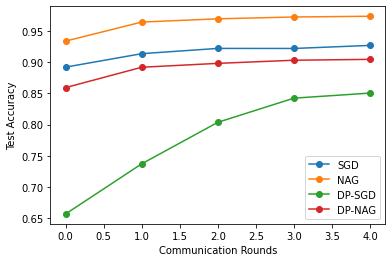

In [19]:
import matplotlib.pyplot as plt

Rounds = 5

Workers = 2

#SGD 
sgd_time, sgd_history, sgd_losses, sgd_accuracies = Simulate_Mnist(Rounds,Workers,64,False,False)

#NAG
nag_time, nag_history, nag_losses, nag_accuracies = Simulate_Mnist(Rounds,Workers,64,False,True)

#DP-SGD
dpsgd_time, dpsgd_history, dpsgd_losses, dpsgd_accuracies = Simulate_Mnist(Rounds,Workers,64,True,False)

#DP-NAG
dpnag_time, dpnag_history, dpnag_losses, dpnag_accuracies = Simulate_Mnist(Rounds,Workers,64,True,True)

# plot accuracies
plt.plot(range(Rounds), sgd_accuracies, "-o", label = "SGD")
plt.plot(range(Rounds), nag_accuracies, "-o", label = "NAG")
plt.plot(range(Rounds), dpsgd_accuracies, "-o", label = "DP-SGD")
plt.plot(range(Rounds), dpnag_accuracies, "-o", label = "DP-NAG")
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

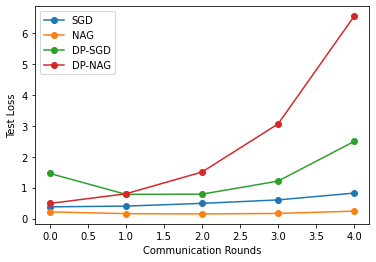

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(Rounds), sgd_losses, "-o", label = "SGD")
plt.plot(range(Rounds), nag_losses, "-o", label = "NAG")
plt.plot(range(Rounds), dpsgd_losses, "-o", label = "DP-SGD")
plt.plot(range(Rounds), dpnag_losses, "-o", label = "DP-NAG")
plt.xlabel('Communication Rounds')
plt.ylabel('Test Loss')
plt.legend()
plt.show()

The loss here is hard to see, so instead of one big plot I split the code into two plots just to make things more visible.

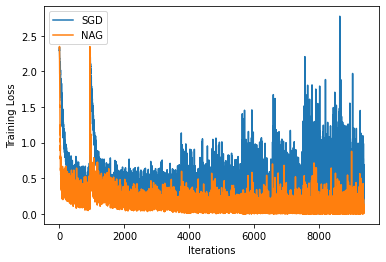

In [21]:
plt.plot(range(len(sgd_history)), sgd_history, label = "SGD")
plt.plot(range(len(sgd_history)), nag_history,  label = "NAG")
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

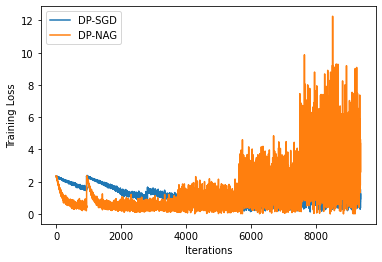

In [22]:
plt.plot(range(len(sgd_history)), dpsgd_history,  label = "DP-SGD")
plt.plot(range(len(sgd_history)), dpnag_history,  label = "DP-NAG")
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Running times 

The code below generates the plot for running times. It is easy to see that the running time for DP optimizers is always extremely larger compared to normal optimizers. See presentation (and link specifically) to see what reasons affected this behavior.

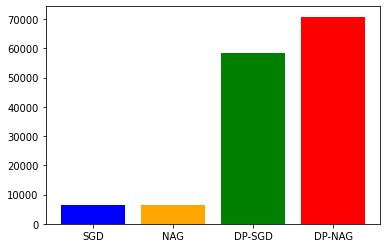

In [23]:
import numpy as np
# create a dataset
height = [sgd_time, nag_time, dpsgd_time, dpnag_time]
bars = ('SGD', 'NAG', 'DP-SGD', 'DP-NAG')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['blue', 'orange', 'green', 'red'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

# Show graph
plt.show()

# Differential Privacy Comparison and Privacy parameters selection

The code below illustrates how selection of privacy parameters affects the results. 

To select noiseScale (σ) we use the following equation:

$\sigma = \sqrt{2\ln \frac{1.25}{\delta}}/\epsilon$

ϵ and δ here are parameters of (ϵ, δ) - differential privacy.

The use of the following σ guarantees the corresponding level of (ϵ, δ) - differential privacy on one iteration of the algorihm.

So, from above, for example for: 

fixed δ = 1.0, ϵ =  0.5, we have σ = 1.33609

fixed δ = 1.0, ϵ =  0.7, we have σ = 0.95435

fixed δ = 1.0, ϵ =  1.65, we have σ = 0.4

For multiple steps, we have immeditate guarantee of (qTϵ, qTσ) - differential privacy (see presentation). This bound can be further improved using theorems like Advanced Composition, Moments Accountant, etc.

**Note 1:** Note that clip constant, *c* has no direct effect on the differential privacy. We only care about the fact that it exists, meaning that we bound our gradients, which enables Gaussian Mechanism to provide us with some differential privacy guarantees. In reality, however, this parameter may be used by adversaries to detect big change in gradients, which makes it easier for them to perform privacy attacks.

**Note 2:** Speaking of practical selection of parameters, Opacus also implements a method to account for differential privacy using Renyi differential privacy. This can be done automatically, by setting some parameters in the Opacus privacy engine. I did not run/include any of this for presentation, but this is actually a way to do it in practice.

In [24]:
import matplotlib.pyplot as plt

Rounds = 5

Workers = 1

dpsgd_time_one, dpsgd_history_two, dpsgd_losses_two, dpsgd_accuracies_two = Simulate_Mnist(Rounds,Workers,64,True,False, learnRate=0.01, momentumRate=0.9, noiseScale=1.33609, clipConstant=1.0)
dpnag_time_one, dpnag_history_two, dpnag_losses_two, dpnag_accuracies_two = Simulate_Mnist(Rounds,Workers,64,True,True, learnRate=0.01, momentumRate=0.9, noiseScale=1.33609, clipConstant=1.0)

dpsgd_time_two, dpsgd_history_two, dpsgd_losses_two, dpsgd_accuracies_two = Simulate_Mnist(Rounds,Workers,64,True,False, learnRate=0.01, momentumRate=0.9, noiseScale=0.95435, clipConstant=1.0)
dpnag_time_two, dpnag_history_two, dpnag_losses_two, dpnag_accuracies_two = Simulate_Mnist(Rounds,Workers,64,True,True, learnRate=0.01, momentumRate=0.9, noiseScale=0.95435, clipConstant=1.0)

dpsgd_time_three, dpsgd_history_three, dpsgd_losses_three, dpsgd_accuracies_three = Simulate_Mnist(Rounds,Workers,64,True,False, learnRate=0.01, momentumRate=0.9, noiseScale=0.4, clipConstant=1.0)
dpnag_time_three, dpnag_history_three, dpnag_losses_three, dpnag_accuracies_three = Simulate_Mnist(Rounds,Workers,64,True,True, learnRate=0.01, momentumRate=0.9, noiseScale=0.4, clipConstant=1.0)



/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:115: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Client:  1
Epoch:  1 [    0/60032 (  0%)]	Loss: 2.337021
Epoch:  1 [ 6400/60032 ( 11%)]	Loss: 2.245985
Epoch:  1 [12800/60032 ( 21%)]	Loss: 2.202093
Epoch:  1 [19200/60032 ( 32%)]	Loss: 2.060123
Epoch:  1 [25600/60032 ( 43%)]	Loss: 1.998044
Epoch:  1 [32000/60032 ( 53%)]	Loss: 1.971990
Epoch:  1 [38400/60032 ( 64%)]	Loss: 1.833811
Epoch:  1 [44800/60032 ( 75%)]	Loss: 1.806936
Epoch:  1 [51200/60032 ( 85%)]	Loss: 1.629165
Epoch:  1 [57600/60032 ( 96%)]	Loss: 1.648629
Averaging


Test set: Average loss: 1.0265, Accuracy: 6701/10000 (67%)

Client:  1
Epoch:  2 [    0/60032 (  0%)]	Loss: 1.253687
Epoch:  2 [ 6400/60032 ( 11%)]	Loss: 0.960998
Epoch:  2 [12800/60032 ( 21%)]	Loss: 0.718079
Epoch:  2 [19200/60032 ( 32%)]	Loss: 0.845977
Epoch:  2 [25600/60032 ( 43%)]	Loss: 0.783687
Epoch:  2 [32000/60032 ( 53%)]	Loss: 0.662612


KeyboardInterrupt: ignored

The code below produces the plot for accuracy of setup described above.

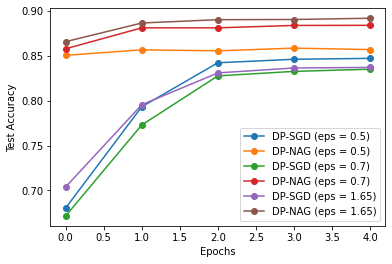

In [ ]:
import matplotlib.pyplot as plt
Rounds = 5
# plot accuracies
plt.plot(range(Rounds), dpsgd_accuracies_one, "-o", label = "DP-SGD (eps = 0.5)")
plt.plot(range(Rounds), dpnag_accuracies_one, "-o", label = "DP-NAG (eps = 0.5)")
plt.plot(range(Rounds), dpsgd_accuracies_two, "-o", label = "DP-SGD (eps = 0.7)")
plt.plot(range(Rounds), dpnag_accuracies_two, "-o", label = "DP-NAG (eps = 0.7)")
plt.plot(range(Rounds), dpsgd_accuracies_three, "-o", label = "DP-SGD (eps = 1.65)")
plt.plot(range(Rounds), dpnag_accuracies_three, "-o", label = "DP-NAG (eps = 1.65)")
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()